**Training Code**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose, BatchNormalization
from keras.layers import LeakyReLU, ReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
import matplotlib.pyplot as plt

In [ ]:
def define_discriminator(image_shape = (256,256,3)):
    # Input layer for real or generated image
    in_image = Input(shape=image_shape)

    # Downsample to 128x128x64
    d = Conv2D(64, (4, 4), strides=(2, 2), padding='same')(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    d = Dropout(0.25)(d)

    # Downsample to 64x64x128
    d = Conv2D(128, (4, 4), strides=(2, 2), padding='same')(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Dropout(0.25)(d)

    # Downsample to 32x32x256
    d = Conv2D(256, (4, 4), strides=(2, 2), padding='same')(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Dropout(0.25)(d)

    # Flatten and output a single classification value
    d = Flatten()(d)
    d = Dense(1, activation='sigmoid')(d)

    # Define model
    model = Model(in_image, d)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# Test the discriminator
image_shape = (256, 256, 3)
discriminator = define_discriminator(image_shape)
discriminator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 262144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │         262,145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 921,025 (3.51 MB)

 Trainable params: 921,025 (3.51 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def define_generator(latent_dim):
    # Image generator input
    in_lat = Input(shape=(latent_dim,))
    # Foundation for 32x32 image
    n_nodes = 32 * 32 * 256
    gen = Dense(n_nodes)(in_lat)  # shape = 262,144
    gen = Reshape((32, 32, 256))(gen)  # Shape =
    gen = BatchNormalization()(gen)
    gen = ReLU()(gen)

    # Upsample to each image to 64x64x128
    gen = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(gen)
    gen = BatchNormalization()(gen)
    gen = ReLU()(gen)
    # Upsample to each image to 128x128x64
    gen = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same')(gen)
    gen = BatchNormalization()(gen)
    gen = ReLU()(gen)
    # Upsample to each image to 256x256x32
    gen = Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same')(gen)
    gen = BatchNormalization()(gen)
    gen = ReLU()(gen)

    # Output layer ==> 256x256x3
    out_layer = Conv2D(3, (8, 8), activation='tanh', padding='same')(gen)

    # Define model
    model = Model(in_lat, out_layer)
    return model  # Model not compiled as it is not directly trained like the discriminator.

# Test the generator
test_gen = define_generator(128)
print(test_gen.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 262144)              │      33,816,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 64, 64, 128)         │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 128, 128, 64)        │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 256, 256, 32)        │          32,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 256, 256, 3)         │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,512,995 (131.66 MB)

 Trainable params: 34,512,035 (131.65 MB)

 Non-trainable params: 960 (3.75 KB)

None


In [ ]:

def define_gan(g_model, d_model):
	d_model.trainable = False
	#Connecting the Generator and Discriminator
	gen_noise = g_model.input
	gen_output = g_model.output  #256x256x3
	print("(define_gan): gen_output: ",gen_output)
	gan_output = d_model(gen_output)

	model = Model(gen_noise, gan_output)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X = images[ix]
	y = ones((n_samples, 1))  #Label=1 indicating they are real
	return X, y
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input])
	# create class labels
	y = zeros((n_samples, 1))  #Label=0 indicating they are fake
	return images, y

In [ ]:
from sklearn.model_selection import train_test_split
import os
import shutil

# Define the path to the dataset folder
dataset_folder = '/content/drive/MyDrive/SPNCAI Workshop/GAN Code+Weights+Dataset/TeaLeaves'

# Get the list of image filenames in the dataset folder
image_files = [os.path.join(dataset_folder, file)
for file in os.listdir(dataset_folder)
if file.endswith('.jpg') or file.endswith('.png')]

# Define the ratio for splitting the dataset into training and testing sets
test_size = 0.1

# Split the dataset into training and testing sets
train_files, test_files = train_test_split(image_files, test_size=test_size, random_state=42)

# Print the number of images in each set
print("Number of images in training set:", len(train_files))
print("Number of images in testing set:", len(test_files))

# Optionally, you can move the files to separate training and testing folders
train_folder = '/content/drive/MyDrive/SPNCAI Workshop/GAN Code+Weights+Dataset/train_dataset'
test_folder = '/content/drive/MyDrive/SPNCAI Workshop/GAN Code+Weights+Dataset/test_dataset'

# Create the training and testing folders if they don't exist
if not os.path.exists(train_folder):
    os.makedirs(train_folder)
if not os.path.exists(test_folder):
    os.makedirs(test_folder)

# Move training images to the train folder
for file in train_files:
    filename = os.path.basename(file)
    dest_path = os.path.join(train_folder, filename)
    shutil.copyfile(file, dest_path)

# Move testing images to the test folder
for file in test_files:
    filename = os.path.basename(file)
    dest_path = os.path.join(test_folder, filename)
    shutil.copyfile(file, dest_path)

print("Dataset split and saved into training and testing folders.")

Number of images in training set: 795
Number of images in testing set: 89
Dataset split and saved into training and testing folders.


In [ ]:
from PIL import Image
import os
import numpy as np

# Define the paths to the training and testing folders
train_folder = '/content/drive/MyDrive/SPNCAI Workshop/GAN Code+Weights+Dataset/train_dataset'
test_folder = '/content/drive/MyDrive/SPNCAI Workshop/GAN Code+Weights+Dataset/test_dataset'

# Initialize lists to store the image data
x_train = []
x_test = []

# Resize function
def resize_image(img, size=(256, 256)):
    return img.resize(size)

# Read images from the training folder
for filename in os.listdir(train_folder):
    img_path = os.path.join(train_folder, filename)
    img = Image.open(img_path)
    img_resized = resize_image(img)  # Resize the image to 256x256
    img_data = np.array(img_resized)  # Convert image to numpy array
    x_train.append(img_data)

# Read images from the testing folder
for filename in os.listdir(test_folder):
    img_path = os.path.join(test_folder, filename)
    img = Image.open(img_path)
    img_resized = resize_image(img)  # Resize the image to 256x256
    img_data = np.array(img_resized)  # Convert image to numpy array
    x_test.append(img_data)

# Convert lists to numpy arrays
x_train = np.array(x_train)
x_test = np.array(x_test)

# Print the shapes of the arrays
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

Shape of x_train: (877, 256, 256, 3)
Shape of x_test: (171, 256, 256, 3)


In [ ]:
x_train.shape

(877, 256, 256, 3)

In [ ]:
print(x_train.min())  # Minimum pixel value
print(x_train.max()) # Maximum pixel value

0
255


(877, 256, 256, 3) (171, 256, 256, 3)
Shape of x_train: (877, 256, 256, 3)
Shape of x_test: (171, 256, 256, 3)


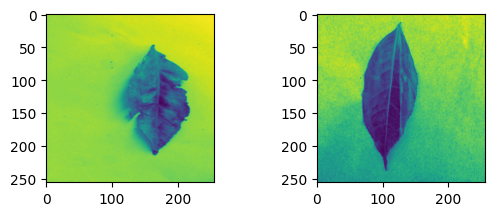

In [ ]:
#Convert data into Floating point numbers and Normalize
x_train = np.array(x_train)
x_test = np.array(x_test)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train,x_test=x_train/255.0,x_test/255.0
print(x_train.shape,x_test.shape)
img_width = x_train.shape[1]
img_height = x_train.shape[2]
num_channels = 3
x_train = x_train.reshape(x_train.shape[0], img_height, img_width, num_channels)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, num_channels)
# Print the shapes of the arrays
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
input_shape = (img_height, img_width, num_channels)
plt.figure(1)

plt.subplot(221)
plt.imshow(x_train[300][:,:,0])

plt.subplot(222)
plt.imshow(x_test[10][:,:,0])

In [ ]:
print(x_train.min())  # Minimum pixel value
print(x_train.max()) # Maximum pixel value

0.0
1.0


In [ ]:
x_train.shape

(877, 256, 256, 3)

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=32, subset_size=None):
    if subset_size is not None:
        dataset_subset = (dataset[0][:subset_size], dataset[1][:subset_size])
    else:
        dataset_subset = dataset

    batch_per_epoch = int(dataset_subset[0].shape[0] / n_batch)
    print("batch_per_epoch: ",  batch_per_epoch)
    half_batch = int(n_batch / 2)

    for i in range(n_epochs):
        print(f'Epoch {i+1}/{n_epochs}')
        for j in range(batch_per_epoch):
              # Train discriminator on real samples
              X_real, y_real = generate_real_samples(dataset_subset, half_batch)
              d_loss_real = d_model.train_on_batch(X_real, y_real)[0]

              # Train discriminator on fake samples
              X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
              d_loss_fake = d_model.train_on_batch(X_fake, y_fake)[0]

              # Train generator
              z_input = generate_latent_points(latent_dim, n_batch)
              y_gan = np.ones((n_batch, 1))
              g_loss = gan_model.train_on_batch(z_input, y_gan)[0]

              # Print losses on this batch
              print(f'Batch {j+1}/{batch_per_epoch}, d_loss_real = {d_loss_real:.3f}, d_loss_fake = {d_loss_fake:.3f}, g_loss = {g_loss:.3f}')


    google_drive_path = '/content/drive/MyDrive/SPNCAI Workshop/GAN Code+Weights+Dataset/Weights/'
    # Save the model weights to Google Drive
    g_model.save(google_drive_path + 'GAN_Tea_Disease.h5')
    # Save the generator model
    g_model.save_weights(google_drive_path + 'GAN_Tea_Disease.weights.h5')

# Train the GAN
latent_dim = 128
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = x_train
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=5, n_batch=32)


(define_gan): gen_output:  <KerasTensor shape=(None, 256, 256, 3), dtype=float32, sparse=False, name=keras_tensor_53>


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


batch_per_epoch:  8
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Batch 1/8, d_loss_real = 0.684, d_loss_fake = 0.688, g_loss = 0.688
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Batch 2/8, d_loss_real = 0.677, d_loss_fake = 0.681, g_loss = 0.681
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Batch 3/8, d_loss_real = 0.680, d_loss_fake = 0.683, g_loss = 0.683
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Batch 4/8, d_loss_real = 0.681, d_loss_fake = 0.683, g_loss = 0.683
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Batch 5/8, d_loss_real = 0.683, d_loss_fake = 0.684, g_loss = 0.684
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Batch 6/8, d_loss_real = 0.684, d_loss_fake = 0.684, g_loss = 0.684
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Batch 7/8, d_loss_real = 0.685, d_loss_fake = 0.685, g_loss = 0.685
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Batch 8/8, d_loss_real = 0.684, d_loss_fake = 0.685, g_loss = 0.685
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Batch 1/8, d_loss_real = 0.684, d_loss_fake = 0.685, g_loss = 0.685
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Batch 2/8, d_loss_real = 0.684, d_loss_fake = 0.685, g_loss = 0.685
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Batch 3/8, d_loss_real = 0.684, d_lo

Batch 8/8, d_loss_real = 0.684, d_loss_fake = 0.684, g_loss = 0.684


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step


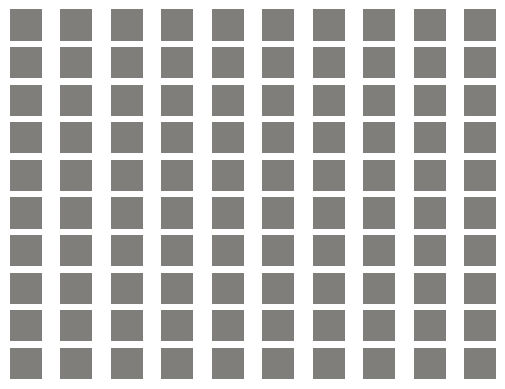

(128, 256, 256, 3)

In [ ]:

from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
import numpy as np


# load model
google_drive_path = '/content/drive/MyDrive/SPNCAI Workshop/GAN Code+Weights+Dataset/Weights/'
model = load_model(google_drive_path + 'GAN_Tea_Disease.h5')

latent_points = generate_latent_points(128, 128)

# generate images
X  = model.predict([latent_points])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)
# plot the result (10 sets of images, all images in a column should be of same class in the plot)
# Plot generated images
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()

show_plot(X, 10)

X.shape


**Inference Code**

In [ ]:

import torch
import torch.nn as nn


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity(),
        )

    def forward(self, x):
        return self.conv(x)


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)


class Generator(nn.Module):
    def __init__(self, img_channels, num_features=64, num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                img_channels,
                num_features,
                kernel_size=7,
                stride=1,
                padding=3,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(
                    num_features, num_features * 2, kernel_size=3, stride=2, padding=1
                ),
                ConvBlock(
                    num_features * 2,
                    num_features * 4,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                )
                # ConvBlock(
                #     num_features * 4,
                #     num_features * 8,
                #     kernel_size=3,
                #     stride=2,
                #     padding=1,
                # ),
            ]
        )
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.ModuleList(
            [
                # ConvBlock(
                #     num_features * 8,
                #     num_features * 4,
                #     down=False,
                #     kernel_size=3,
                #     stride=2,
                #     padding=1,
                #     output_padding=1,
                # ),
                ConvBlock(
                    num_features * 4,
                    num_features * 2,
                    down=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                ConvBlock(
                    num_features * 2,
                    num_features * 1,
                    down=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),

            ]
        )

        self.last = nn.Conv2d(
            num_features * 1,
            img_channels,
            kernel_size=7,
            stride=1,
            padding=3,
            padding_mode="reflect",
        )

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))


def test():
    img_channels = 3
    img_size = 200
    x = torch.randn((2, img_channels, img_size, img_size))
    gen = Generator(img_channels, 9)
    print(gen(x).shape)


if __name__ == "__main__":
    test()


torch.Size([2, 3, 200, 200])


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt

# Define the necessary transforms for the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Adjust normalization parameters if necessary
])

def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)

def save_image(tensor, output_dir, image_name):
    image = tensor.cpu().clone().squeeze(0)
    image = transforms.ToPILImage()(image)
    image.save(os.path.join(output_dir, image_name))

def generate_and_show_images(generator, device, input_dir):
    for image_name in os.listdir(input_dir):
        image_path = os.path.join(input_dir, image_name)
        original_image = load_image(image_path)
        image = original_image.to(device)

        with torch.no_grad():
            fake_image = generator(image)

        # Adjust brightness by scaling pixel values
        fake_image = (fake_image + 1) / 2
        original_image = (original_image + 1) / 2
        # Clamp pixel values to ensure they are within [0, 1] range
        fake_image = torch.clamp(fake_image, 0, 1)
        original_image = torch.clamp(original_image, 0, 1)
        # Display original and generated images side by side
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(original_image.squeeze().permute(1, 2, 0))
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        axes[1].imshow(fake_image.squeeze().permute(1, 2, 0))
        axes[1].set_title('Generated Image')
        axes[1].axis('off')
        plt.show()

# Parameters
input_dir = '/content/drive/MyDrive/SPNCAI Workshop/PreTrainedGAN Dataset+Weights/TestImages/healthy'
model_path = '/content/drive/MyDrive/SPNCAI Workshop/PreTrainedGAN Dataset+Weights/NewWeights/gen_multiple_disease.pth.tar'  # Change to your model path

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the trained generator model
generator = Generator(img_channels=3, num_residuals=9).to(device)
checkpoint = torch.load(model_path, map_location=device)
generator.load_state_dict(checkpoint['state_dict'])
generator.eval()

generate_and_show_images(generator, device, input_dir)


Output hidden; open in https://colab.research.google.com to view.